In [2]:
import os
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy.optimize import Bounds, LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize import minimize
import seaborn as sns
from numpy import random
from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.isotonic import IsotonicRegression
from scipy.stats import multivariate_normal

import multiprocessing as mp
from joblib import Parallel, delayed
import seaborn as sns
from tqdm import tqdm
num_cores = mp.cpu_count()

from utils import *
from simu_recalib import *

# plot
import seaborn as sns
sns.set_theme()
sns.set_context("notebook")
import matplotlib.pyplot as plt
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [226]:
n1, n2 = 1000, 500
repN = 1000
d = 20
mu_shift = 2.0
alpha = 0.1
f_div = 'kl'
mis = True
t_seq = [0.0, 6.0]

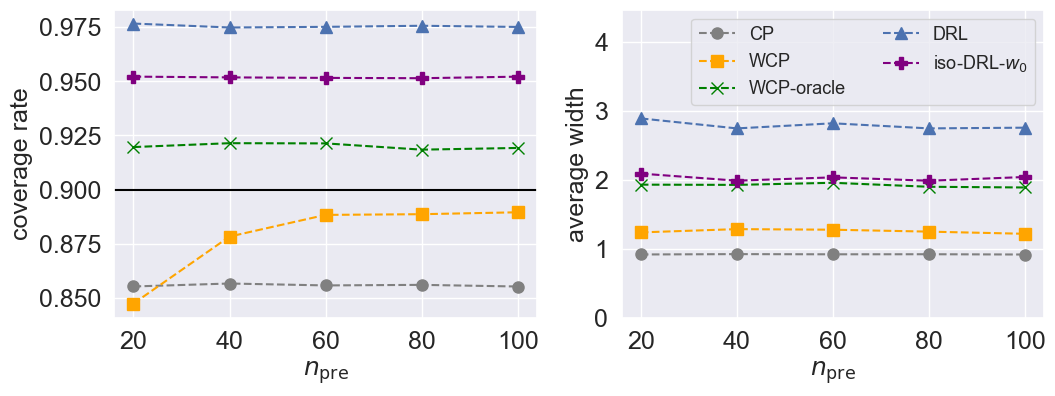

In [227]:
setting = "pre_rt"
n_seq = [20, 40, 60, 80, 100]
for t_idx in [5.0]:
    cov_0 = []
    cov_wt = []
    cov_wt_oracle = []
    cov_dro = []
    cov_iso = []
    cov_rob = []

    len_0 = []
    len_wt = []
    len_wt_oracle = []
    len_dro = []
    len_iso = []
    len_rob = []


    for n_pre in n_seq:
        
        file_dir1 = './result/result_1/cov_%s_%s_%s_%s_%s_%s_%s_%s_%s_%s.csv'% (n1,n2,d,repN,f_div,n_pre,mu_shift,t_idx,mis,setting)
        file_dir2 = './result/result_1/len_%s_%s_%s_%s_%s_%s_%s_%s_%s_%s.csv'% (n1,n2,d,repN,f_div,n_pre,mu_shift,t_idx,mis,setting)
        plot_dir = './figs/plot_n_%s_%s_%s_%s_%s_%s_%s_%s_%s.pdf'%(n1,n2,d,repN,f_div,mu_shift,t_idx,mis,setting)
        df_cov = pd.read_csv(file_dir1)
        df_len = pd.read_csv(file_dir2)

        cov_0.append(np.mean(df_cov.to_numpy()[:,0]))
        cov_wt.append(np.mean(df_cov.to_numpy()[:,1]))
        cov_wt_oracle.append(np.mean(df_cov.to_numpy()[:,2]))
        cov_dro.append(np.mean(df_cov.to_numpy()[:,3]))
        cov_iso.append(np.mean(df_cov.to_numpy()[:,4]))
        cov_rob.append(np.mean(df_cov.to_numpy()[:,5]))

        len_0.append(np.mean(df_len.to_numpy()[:,0]))
        len_wt.append(np.mean(df_len.to_numpy()[:,1]))
        len_wt_oracle.append(np.mean(df_len.to_numpy()[:,2]))
        len_dro.append(np.mean(df_len.to_numpy()[:,3]))
        len_iso.append(np.mean(df_len.to_numpy()[:,4]))
        len_rob.append(np.mean(df_len.to_numpy()[:,5]))

    fig, ax = plt.subplots(1,2,figsize=(12,4))
    ax[0].plot(n_seq, cov_0, c='gray', marker='o', linestyle='--', markersize=8, label='CP')
    ax[0].plot(n_seq, cov_wt, c='orange', marker='s', linestyle='--', markersize=8, label='WCP')
    ax[0].plot(n_seq, cov_wt_oracle, c='green', marker='x', linestyle='--', markersize=8, label='WCP-oracle')
    ax[0].plot(n_seq, cov_dro, 'b^--', markersize=8, label='DRL')
    ax[0].plot(n_seq, cov_iso, c='purple', marker='P', linestyle='--', markersize=8, label=r'iso-DRL-$w_0$')
    ax[0].set_ylabel('coverage rate')
    ax[0].set_xlabel(r'$n_{\rm pre}$')
    ax[0].axhline(y=1-alpha, c='black', linestyle='-')

    ax[1].plot(n_seq, len_0, c='gray', marker='o', linestyle='--', markersize=8, label='CP')
    ax[1].plot(n_seq, len_wt, c='orange', marker='s', linestyle='--', markersize=8, label='WCP')
    ax[1].plot(n_seq, len_wt_oracle, c='green', marker='x', linestyle='--', markersize=8, label='WCP-oracle')
    ax[1].plot(n_seq, len_dro, 'b^--', markersize=8, label='DRL')
    ax[1].plot(n_seq, len_iso, c='purple', marker='P', linestyle='--', markersize=8, label=r'iso-DRL-$w_0$')
    ax[1].set_ylabel('average width')
    ax[1].set_xlabel(r'$n_{\rm pre}$')
    ax[1].set_ylim((0,1.3*max(np.max(len_dro),np.max(len_rob))))
    ax[1].legend(loc='best', ncol=2, prop={'size': 13})
    plt.savefig(plot_dir, bbox_inches='tight')


(1000, 5)
(1000, 5)


<Figure size 640x480 with 0 Axes>

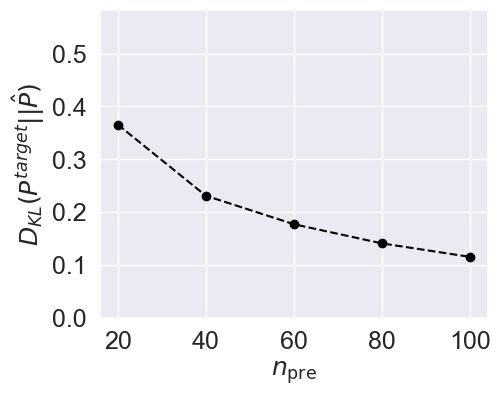

<Figure size 640x480 with 0 Axes>

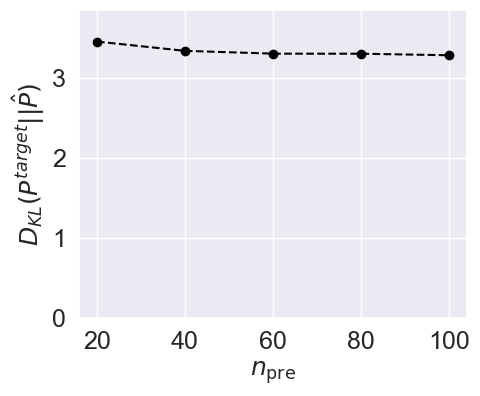

In [156]:
# plot estimated KL
for t_idx in t_seq:
    file_dir = './result/result/rho_%s_%s_%s_%s_%s_%s_%s.csv'% (n1,n2,repN,f_div,mu_shift,t_idx,mis)
    rho_hat_df = pd.read_csv(file_dir)
    print(rho_hat_df.shape)

    plt.figure()
    fig, ax = plt.subplots(1,1,figsize=(5,4))

    rho_mean = rho_hat_df.mean()
    rho_se = np.sqrt(rho_hat_df.var())
    ax.plot(n_seq, rho_mean, 'o--', color='black')
    ax.set_xlabel(r'$n_{\rm pre}$')
    ax.set_ylabel(r'$D_{KL}(P^{target}||\hat{P})$')

    ylim_rho = rho_mean.max() + rho_se.max()
    ax.set_ylim((0,ylim_rho))
    plot_dir_rho = './plot/kl_%s_%s_%s_%s.pdf'%(repN,mu_shift,t_idx,mis)
    plt.savefig(plot_dir_rho, bbox_inches='tight')

(200, 803)
(200, 803)


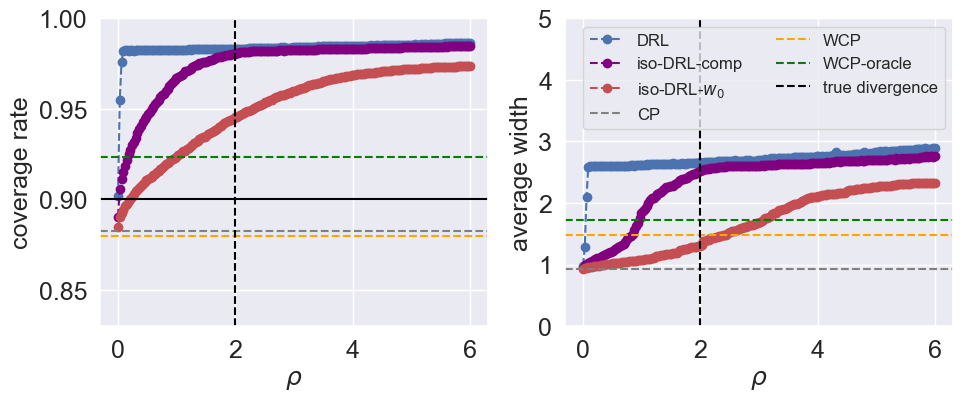

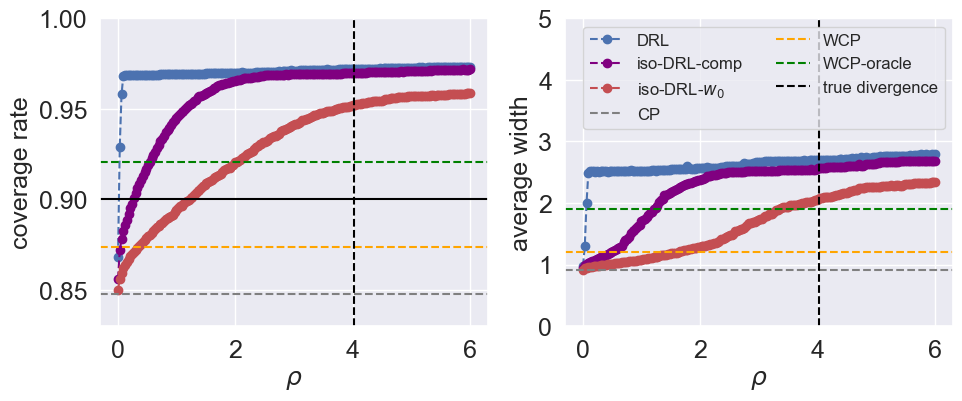

In [234]:
repN = 200
setting = "rho"
n_pre = 50
rho_seq = np.linspace(0.002, 6, 200)
other_order = True

for t_idx in t_seq:
    file_dir1 = './result/result_1/cov_%s_%s_%s_%s_%s_%s_%s_%s_%s_%s.csv'% (n1,n2,d,repN,f_div,n_pre,mu_shift,t_idx,mis,setting)
    file_dir2 = './result/result_1/len_%s_%s_%s_%s_%s_%s_%s_%s_%s_%s.csv'% (n1,n2,d,repN,f_div,n_pre,mu_shift,t_idx,mis,setting)
    if other_order:
        plot_dir = './plot/plot_rho_%s_%s_%s_%s_%s_%s_%s_%s_%s_%s_order.pdf'% (n1,n2,d,repN,f_div,n_pre,mu_shift,t_idx,mis,setting)
    else:
        plot_dir = './plot/plot_rho_%s_%s_%s_%s_%s_%s_%s_%s_%s_%s.pdf'% (n1,n2,d,repN,f_div,n_pre,mu_shift,t_idx,mis,setting)
    df_cov = pd.read_csv(file_dir1)
    df_len = pd.read_csv(file_dir2)
    
    print(df_cov.shape)

    rho_star = 0.5*((mu_shift)**2 + t_idx - np.log(1+t_idx))

    os.makedirs(os.path.dirname(plot_dir), exist_ok=True)

    cov_0 = np.mean(df_cov.to_numpy()[:,0])
    cov_wt = np.mean(df_cov.to_numpy()[:,1])
    cov_wt_oracle = np.mean(df_cov.to_numpy()[:,2])
    len_0 = np.mean(df_len.to_numpy()[:,0])
    len_wt = np.mean(df_len.to_numpy()[:,1])
    len_wt_oracle = np.mean(df_len.to_numpy()[:,2])


    cov_dro = np.mean(df_cov.to_numpy()[:,3:(3+len(rho_seq))], axis=0)
    
    if other_order:
        cov_isodro = np.mean(df_cov.to_numpy()[:,(3+len(rho_seq)):(3+2*len(rho_seq))], axis=0)
        cov_isodro1 = np.mean(df_cov.to_numpy()[:,(3+2*len(rho_seq)):(3+3*len(rho_seq))], axis=0)
    else:
        cov_isodro = np.mean(df_cov.to_numpy()[:,(3+2*len(rho_seq)):(3+3*len(rho_seq))], axis=0)

    len_dro = np.mean(df_len.to_numpy()[:,3:(3+len(rho_seq))], axis=0)
    if other_order:
        len_isodro = np.mean(df_len.to_numpy()[:,(3+len(rho_seq)):(3+2*len(rho_seq))], axis=0)
        len_isodro1 = np.mean(df_len.to_numpy()[:,(3+2*len(rho_seq)):(3+3*len(rho_seq))], axis=0)
    else:
        len_isodro = np.mean(df_len.to_numpy()[:,(3+2*len(rho_seq)):(3+3*len(rho_seq))], axis=0)
        
    fig, ax = plt.subplots(1,2,figsize=(11,4))
    ax[0].plot(rho_seq, cov_dro, 'bo--', markersize=6, label='DRL')
    if other_order:
        ax[0].plot(rho_seq, cov_isodro, c='purple', linestyle='--', marker='o', markersize=6, label='iso-DRL-comp')
        ax[0].plot(rho_seq, cov_isodro1, 'ro--', markersize=6, label=r'iso-DRL-$w_0$')
    else:
        ax[0].plot(rho_seq, cov_isodro, 'ro--', marker='o', markersize=6, label=r'iso-DRL-$w_0$')
    ax[0].set_ylim((0.83,1))
    ax[0].set_ylabel('coverage rate')
    ax[0].set_xlabel(r'$\rho$')
    ax[0].axhline(y=cov_0, c='gray', linestyle='--', label='CP')
    ax[0].axhline(y=cov_wt, c='orange', linestyle='--', label='WCP')
    ax[0].axhline(y=cov_wt_oracle, c='green', linestyle='--', label='WCP-oracle')
    ax[0].axhline(y=1-alpha, c='black', linestyle='-')
    ax[0].axvline(x=rho_star, c='black', linestyle='--', label='true divergence')

    ax[1].plot(rho_seq, len_dro, 'bo--', markersize=6, label='DRL')
    if other_order:
        ax[1].plot(rho_seq, len_isodro, c='purple', linestyle='--', marker='o', markersize=6, label='iso-DRL-comp')
        ax[1].plot(rho_seq, len_isodro1, 'ro--', markersize=6, label=r'iso-DRL-$w_0$')
    else:
        ax[1].plot(rho_seq, len_isodro, 'ro--', marker='o', markersize=6, label=r'iso-DRL-$w_0$')
    ax[1].axhline(y=len_0, c='gray', linestyle='--', label='CP')
    ax[1].axhline(y=len_wt, c='orange', linestyle='--', label='WCP')
    ax[1].axhline(y=len_wt_oracle, c='green', linestyle='--', label='WCP-oracle')
    ax[1].axvline(x=rho_star, c='black', linestyle='--', label='true divergence')
    ax[1].set_ylim((0,5))
    ax[1].set_ylabel('average width')
    ax[1].set_xlabel(r'$\rho$')
    ax[1].legend(loc='best', ncol=2, prop={'size': 12})
    plt.savefig(plot_dir, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

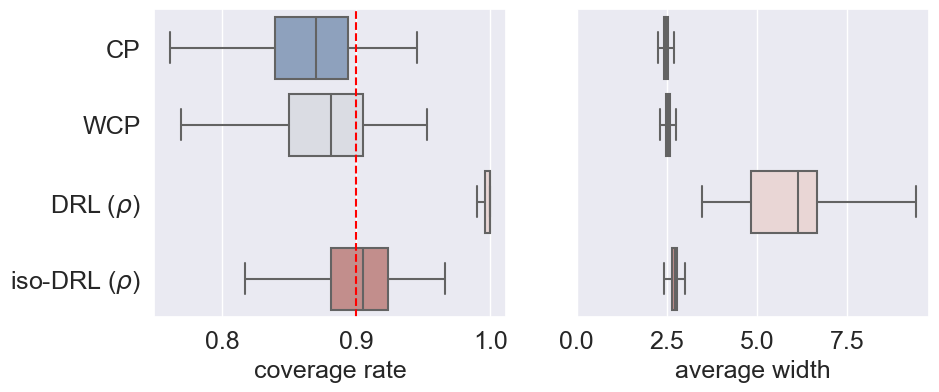

In [181]:
setting = "estimated"
rho_seq = []

f_div = "kl"
n_pre = 40
repN = 1000

file_dir1 = './result/result_wine/cov_wine_%s_%s_%s_%s.csv'% (repN,f_div,n_pre,setting)
file_dir2 = './result/result_wine/len_wine_%s_%s_%s_%s.csv'% (repN,f_div,n_pre,setting)
df_cov = pd.read_csv(file_dir1)
df_len = pd.read_csv(file_dir2)


plt.figure()]
nam = ['CP', 'WCP', 'DRL (%s)'%(r'$\rho$',), 'iso-DRL (%s)'%(r'$\rho$',), 'robust']
nam_ = ['CP', 'WCP', 'robust', 'DRL (%s)'%(r'$\rho$',), 'iso-DRL (%s)'%(r'$\rho$',)]
df_cov.columns = nam
df_len.columns = nam
df_cov = df_cov[nam_]
df_len = df_len[nam_]

df_cov = df_cov.drop(['robust'], axis=1)
df_len = df_len.drop(['robust'], axis=1)


df_melt = pd.melt(df_cov)
df_melt.columns = ['', 'coverage rate']
df_len_melt = pd.melt(df_len)
df_len_melt.columns = ['', 'average width']

fig, ax = plt.subplots(1,2,figsize=(10,4))
plot_dir = './plot/res_wine_%s_%s_%s_%s_%s.pdf'%(repN,f_div,n_pre,setting,df_cov.shape[1])

b0 = sns.boxplot(x='coverage rate',y='',data=df_melt,ax=ax[0],showfliers=False,palette="vlag")
ax[0].axvline(x=1-alpha, c='red', linestyle='--') 

b1 = sns.boxplot(x='average width',y='',data=df_len_melt,ax=ax[1],showfliers=False,palette="vlag")
b1.set(yticklabels=[])
df_len_ = df_len
df_len_ = df_len_.replace({np.inf: df_len_[np.isfinite(df_len_)].max().max(), 
                           -np.inf: df_len_[np.isfinite(df_len_)].min().min()})
ax[1].set_xlim(left=0)
plt.savefig(plot_dir, bbox_inches='tight')

[1.18232076 1.35627522 1.48733264 1.60366797 1.70379854 1.7998106
 1.89138067 1.98288875 2.07721431 2.1690603  2.26501915 2.35816373
 2.45386289 2.54072527 2.62184512 2.69948712 2.77074533 2.84082101
 2.91102736 2.97963649 3.04784265 3.1183487  3.19306122 3.27085362
 3.35092499 3.43318588 3.5207119  3.60267778 3.68450638 3.75658908
 3.82619364 3.9008066  3.96690464 4.03728995 4.10600348 4.18728198
 4.27472207 4.35583107 4.44296886 4.53442779 4.59520143 4.65233494
 4.73965183 4.77897326 4.8531775  4.90698476 4.99775324 5.0326102
 5.1819967  5.18252888]


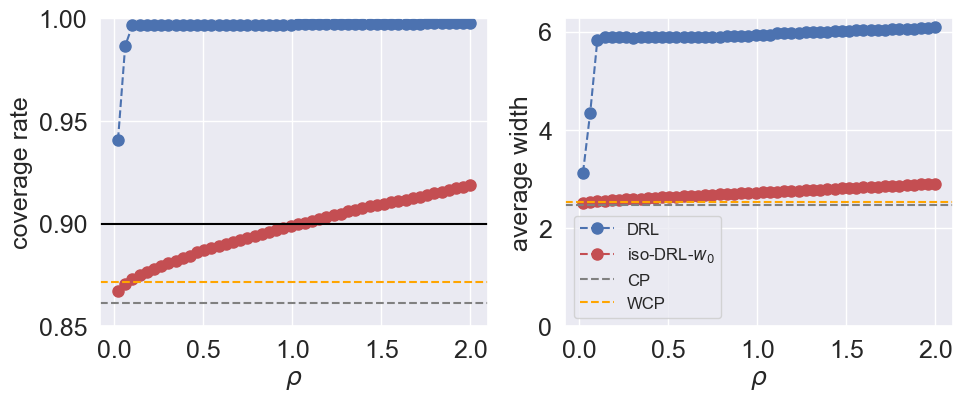

In [186]:
repN = 200
setting = "rho"
rho_seq = np.linspace(0.02, 2, 50)
file_dir1 = './result/result_wine/cov_wine_%s_%s_%s_%s.csv'% (repN,f_div,n_pre,setting)
file_dir2 = './result/result_wine/len_wine_%s_%s_%s_%s.csv'% (repN,f_div,n_pre,setting)
plot_dir = './plot/plot_wine_rho_%s_%s_%s_%s.pdf'%(repN,f_div,pre_rt,setting)
df_cov = pd.read_csv(file_dir1)
df_len = pd.read_csv(file_dir2)

cov_0 = np.mean(df_cov.to_numpy()[:,0])
cov_wt = np.mean(df_cov.to_numpy()[:,1])
len_0 = np.mean(df_len.to_numpy()[:,0])
len_wt = np.mean(df_len.to_numpy()[:,1])

cov_dro = np.mean(df_cov.to_numpy()[:,2:(2+len(rho_seq))], axis=0)
cov_isodro_0 = np.mean(df_cov.to_numpy()[:,(2+len(rho_seq)):(2+2*len(rho_seq))], axis=0)
cov_rob = np.mean(df_cov.to_numpy()[:,(2+2*len(rho_seq)):(2+3*len(rho_seq))], axis=0)

cov_dro_sd = np.sqrt(np.var(df_cov.to_numpy()[:,2:(2+len(rho_seq))], axis=0))
cov_isodro_0_sd = np.sqrt(np.var(df_cov.to_numpy()[:,(2+len(rho_seq)):(2+2*len(rho_seq))], axis=0))
cov_rob_sd = np.sqrt(np.var(df_cov.to_numpy()[:,(2+2*len(rho_seq)):(2+3*len(rho_seq))], axis=0))

len_dro = np.mean(df_len.to_numpy()[:,2:(2+len(rho_seq))], axis=0)
len_isodro_0 = np.mean(df_len.to_numpy()[:,(2+len(rho_seq)):(2+2*len(rho_seq))], axis=0)
len_rob = np.mean(df_len.to_numpy()[:,(2+2*len(rho_seq)):(2+3*len(rho_seq))], axis=0)

print(len_rob)

len_dro_sd = np.sqrt(np.var(df_len.to_numpy()[:,2:(2+len(rho_seq))], axis=0))
len_isodro_0_sd = np.sqrt(np.var(df_len.to_numpy()[:,(2+len(rho_seq)):(2+2*len(rho_seq))], axis=0))
len_rob_sd = np.sqrt(np.var(df_len.to_numpy()[:,(2+2*len(rho_seq)):(2+3*len(rho_seq))], axis=0))

fig, ax = plt.subplots(1,2,figsize=(11,4))
ax[0].plot(rho_seq, cov_dro, 'bo--', markersize=8, label='DRL')
ax[0].plot(rho_seq, cov_isodro_0, 'ro--', markersize=8, label=r'iso-DRL-$w_0$')
ax[0].set_ylim((0.85,1))
ax[0].set_ylabel('coverage rate')
ax[0].set_xlabel(r'$\rho$')
ax[0].axhline(y=cov_0, c='gray', linestyle='--', label='CP')
ax[0].axhline(y=cov_wt, c='orange', linestyle='--', label='WCP')
ax[0].axhline(y=1-alpha, c='black', linestyle='-')

ax[1].plot(rho_seq, len_dro, 'bo--', markersize=8, label='DRL')
ax[1].plot(rho_seq, len_isodro_0, 'ro--', markersize=8, label=r'iso-DRL-$w_0$')
ax[1].axhline(y=len_0, c='gray', linestyle='--', label='CP')
ax[1].axhline(y=len_wt, c='orange', linestyle='--', label='WCP')
ax[1].set_ylim(bottom=0)
ax[1].set_ylabel('average width')
ax[1].set_xlabel(r'$\rho$')
ax[1].legend(loc='best', ncol=1, prop={'size': 12})
plt.savefig(plot_dir, bbox_inches='tight')

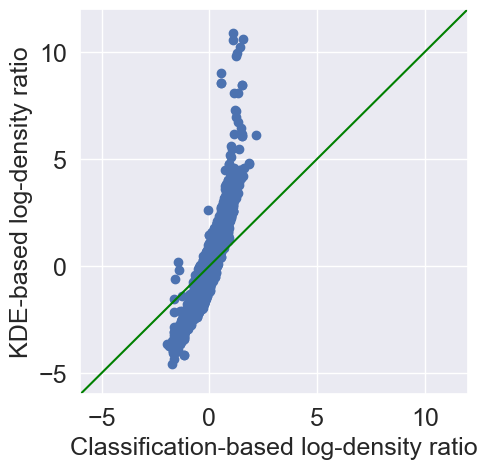

In [188]:
# plot wine dataset
import pandas as pd
import random
from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
random.seed(10)
df_red = pd.read_csv('./wine_quality/winequality-red.csv', delimiter = ';')
df_white = pd.read_csv('./wine_quality/winequality-white.csv', delimiter = ';')

X_red = np.array(df_red)[:,:11]
X_white = np.array(df_white)[:,:11]
y_red = np.array(df_red.quality)
y_white = np.array(df_white.quality)
n_red = X_red.shape[0]
n_white = X_white.shape[0]

X_total = np.concatenate((X_red, X_white), axis=0)

X_rg = np.max(X_total, axis=0)
X_red = X_red / X_rg
X_white = X_white / X_rg
X_total = np.concatenate((X_red, X_white), axis=0)


# pre-fitted
n_pre = 40

a_red = np.arange(n_red)
np.random.shuffle(a_red)
a_white = np.arange(n_white)
np.random.shuffle(a_white)

X_red = X_red[a_red,:]
y_red = y_red[a_red]
X_white = X_white[a_white,:]
y_white = y_white[a_white]

X_white_pre = X_white[:n_pre,:]
X_red_pre = X_red[:n_pre,:]
X_total_pre = np.concatenate((X_red_pre, X_white_pre), axis=0)
label_pre = np.zeros(X_white_pre.shape[0] + X_red_pre.shape[0])
label_pre[X_red_pre.shape[0]:] = 1
clf_pre = LogisticRegression(random_state=0).fit(X_total_pre, label_pre)

marginal_rt = X_white_pre.shape[0] / X_red_pre.shape[0]

    
# a random subsample
s = np.random.uniform(0, 1, n_red+n_white)
subsample_idx = (s < 1)
X_s = X_total[subsample_idx,:]

log_prob_fit = clf_pre.predict_log_proba(X_s)[:,0]
prob_fit = clf_pre.predict_proba(X_s)[:,0]
log_density_ratio_fit = log_prob_fit - np.log(1 - prob_fit) + np.log(marginal_rt)

# KDE
bw_red = 0.125
bw_white = 0.125

kde_red = KernelDensity(bandwidth=bw_red, kernel='gaussian')
kde_red.fit(X_red)
kde_white = KernelDensity(bandwidth=bw_white, kernel='gaussian')
kde_white.fit(X_white)
log_density_ratio = kde_red.score_samples(X_s) - kde_white.score_samples(X_s)

fig, ax = plt.subplots(figsize=(5,5))
plot_dir = './plot/wine_density_ratio.pdf'
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
idx = (np.abs(log_density_ratio_fit) <= 100) & (np.abs(log_density_ratio) <= 100)
ax.plot(log_density_ratio_fit[idx], log_density_ratio[idx] - log_density_ratio_fit[idx], 'bo')
ax.axline([0, 0], [1, 1], c='green')
ax.set_ylabel('KDE-based log-density ratio')
ax.set_xlabel('Classification-based log-density ratio')
lims = [-6, 12]
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.savefig(plot_dir, bbox_inches='tight')

0.8197766419743117


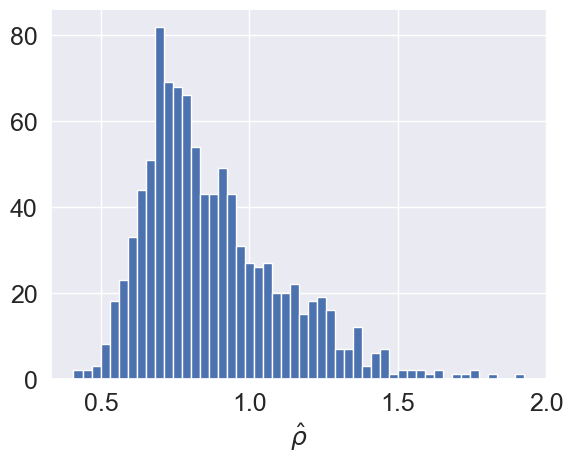

In [75]:
repN = 1000
rho_hat_seq = pd.read_csv('./result/result_wine/rhohat_%s.csv'% (repN))

plot_dir = './plot/wine_rho_hat.pdf'
plt.hist(rho_hat_seq, 50)
plt.xlabel(r'$\hat{\rho}$')
plt.savefig(plot_dir, bbox_inches='tight')

rho_hat = np.median(rho_hat_seq)
print(rho_hat)